In [1]:
import os
import pickle
import shutil
from dataclasses import dataclass, field
from typing import Union
import argparse
from time import perf_counter

import numpy as np
import pandas as pd
import librosa
import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as mplticker
import soundfile as sf

import bruce

DATA = os.path.realpath("../data")
OUTPUT = os.path.join(DATA, "data")
REC = os.path.join(OUTPUT, "reconstructed")
ORIGINAL = os.path.join(OUTPUT, "original")
assert os.path.isdir(ORIGINAL)

BRUCE_MIN_FREQ = 125
BRUCE_MAX_FREQ = 20_000

MIN_FREQ = 150
MAX_FREQ = 10500

n_mels = 80
mel_scale = librosa.filters.mel_frequencies(n_mels, fmin=MIN_FREQ, fmax=MAX_FREQ, htk=False) 

SEED = 12
bruce.set_seed(SEED)
np.random.seed(SEED)

DATA_OVERVIEW = pd.read_pickle("data_overview.pkl")

@dataclass
class Neurogram:
    dt: float
    sample_rate: int 
    f: np.array = field(repr=None)
    t: np.array = field(repr=None)
    data: np.array = field(repr=None)
    stim: bruce.stimulus.Stimulus = None
    name: str = None   
    
    def save(self, path: str):
        with open(path, "wb") as f:    
            pickle.dump(self, f) 

    @staticmethod
    def get(
        path: str, 
        cfs: Union[int, np.array] = 40, 
        bin_width: float = None, 
        n_rep: int = 1,
        n_trials: int = 1,
    ) -> "Neurogram":
        stim = bruce.stimulus.from_file(path, True)
        
        ng = bruce.Neurogram(cfs)
        ng.bin_width = bin_width or stim.time_resolution
        ng.create(stim, n_rep, n_trials)
        
        data = ng.get_output()
        y = ng.get_cfs()
        t = np.arange(data.shape[1]) * ng.bin_width
        return Neurogram(ng.bin_width, int(np.ceil(1 / ng.bin_width)), y, t, data, stim,  name = os.path.basename(path).split(".")[0])

def signal_noise_ratio(preds: np.array, target: np.array, zero_mean: bool = True):
    eps = np.finfo(preds.dtype).eps
    
    if zero_mean:
        target = target - np.mean(target)
        preds = preds - np.mean(preds)
        
    noise = target - preds

    snr_value = (np.sum(target**2) + eps) / (np.sum(noise**2) + eps)
    return 10 * np.log10(snr_value)
    
def min_max_scale(data, a=-80, b=0):
    data_min = np.min(data)
    data_max = np.max(data)
    return a + (data - data_min) * (b - a) / (data_max - data_min)

def make_bins(n, data):
    return data[:, :len(data[0])//n*n].reshape(data.shape[0], -1, n).sum(axis=2)

def apply_filter(
    ng: Neurogram,
    window_type: str = "hann",
    window_size: int = 2048,
    hop_length: int = 512,
    scale: bool = True,
    clip_outliers: float = 0.0,
    n_bins: int = 0,
    resample_to: int = None
):
    data = ng.data.copy()
    if clip_outliers != 0.0:
        q99 = np.quantile(data.ravel(), clip_outliers)
        data[data > q99] = q99

    if n_bins != 0:
        data = make_bins(n_bins, data)
    
    window = scipy.signal.get_window(window_type, window_size)
    wsum = window.sum()
    data = np.vstack(
        [
            (np.convolve(data[i], window, mode="same") / wsum)[::hop_length]
             for i in range(data.shape[0])
        ]
    )
    if scale:
        data = min_max_scale(data)

    if resample_to:
        data = np.array([scipy.signal.resample(x, resample_to) for x in data])
        
    return data



def plot_heatmap(t, y, data, ax = None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 4))
        
    img = ax.pcolormesh(
        t, y, data, cmap="inferno", vmin=data.min(), vmax=data.max()
    )
    ax.set_yscale("symlog", linthresh=1000.0, base=2)
    ax.set_xlabel("time [s]")
    ax.yaxis.set_major_formatter(mplticker.ScalarFormatter())
    ax.yaxis.set_major_locator(mplticker.SymmetricalLogLocator(ax.yaxis.get_transform()))
    ax.yaxis.set_label_text("Hz")
    fig.colorbar(img, ax=ax)

def plot_comparison(ng, S, window_size = 2048, hop_length = None, **kwargs):
    hop_length = hop_length or window_size // 4
    data = apply_filter(
        ng,     
        window_size = window_size,
        hop_length = hop_length,
        **kwargs        
    )
    t = np.linspace(0, ng.stim.stimulus_duration, len(data[0]))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    plot_heatmap(t, ng.f, data, ax1, fig)
    ax1.set_title("neurogram (bruce)")
    
    S_db = librosa.power_to_db(S, ref=np.max)
    ts = np.linspace(0, ng.stim.stimulus_duration, len(S_db[0]))
    
    plot_heatmap(ts, ng.f, S_db, ax2, fig)
    ax2.set_title("spectrogram (sound)")
    
    ref_db = np.max(S)
    mel_spec_ng = librosa.db_to_power(data, ref=ref_db)
    mel_spec_so = librosa.db_to_power(S_db, ref=ref_db)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    plot_heatmap(t, ng.f, mel_spec_ng, ax1, fig)
    ax1.set_title("neurogram (bruce)")
    plot_heatmap(ts, ng.f, mel_spec_so, ax2, fig)
    ax2.set_title("spectrogram (sound)")
    return mel_spec_ng, mel_spec_so

In [2]:
# 14 is sheep thing
for i in range(100):
    tst = DATA_OVERVIEW[DATA_OVERVIEW.label_names.str.contains("Speech")].iloc[i]
    shutil.copyfile(tst.path, os.path.join(ORIGINAL, f"{i}_{os.path.basename(tst.path)}"))    

In [3]:
tst = DATA_OVERVIEW[DATA_OVERVIEW.label_names.str.contains("Speech")].iloc[47]

In [4]:
start = perf_counter()
ng = Neurogram.get(tst.path, cfs=mel_scale, n_trials=10)
perf_counter() - start

loading file: /home/nobeljpde1/hearing_model/data/data/audioset/dataset/data/balanced_train_segments/audio/-WFsDr9xBVo_30000_40000.wav
|======================================|
Num Channels: 1
Num Samples Per Channel: 160000
Sample Rate: 16000
Bit Depth: 16
Length in Seconds: 10
|======================================|


120.57622953597456

In [5]:
S = librosa.feature.melspectrogram(y=np.array(ng.stim.data), sr=ng.stim.sampling_rate, n_mels=n_mels, fmin=MIN_FREQ, fmax=MAX_FREQ)

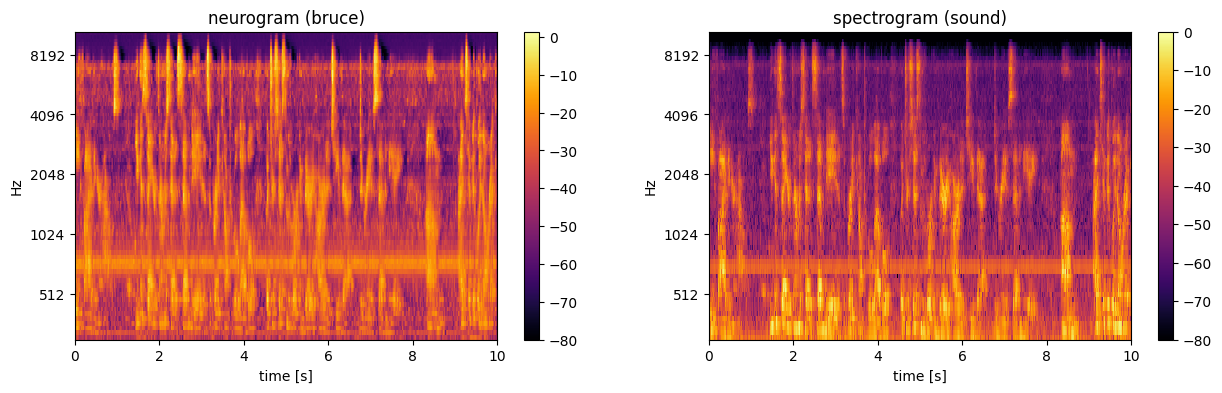

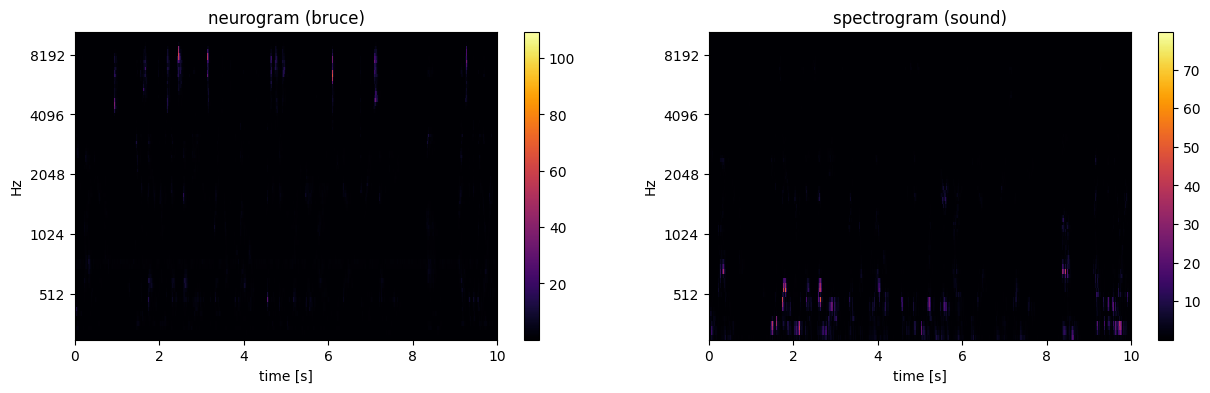

In [6]:
mel_spec_ng, mel_spec_so = plot_comparison(ng, S, window_type='hann', n_bins=3, scale=True, clip_outliers=0., resample_to=S.shape[1])

In [7]:
y = np.array(ng.stim.data)
sr = ng.stim.sampling_rate

mel_inversed = librosa.feature.inverse.mel_to_audio(mel_spec_so, sr=sr, fmin=MIN_FREQ, fmax=MAX_FREQ)
ng_inversed  = librosa.feature.inverse.mel_to_audio(mel_spec_ng, sr=sr, fmin=MIN_FREQ, fmax=MAX_FREQ)

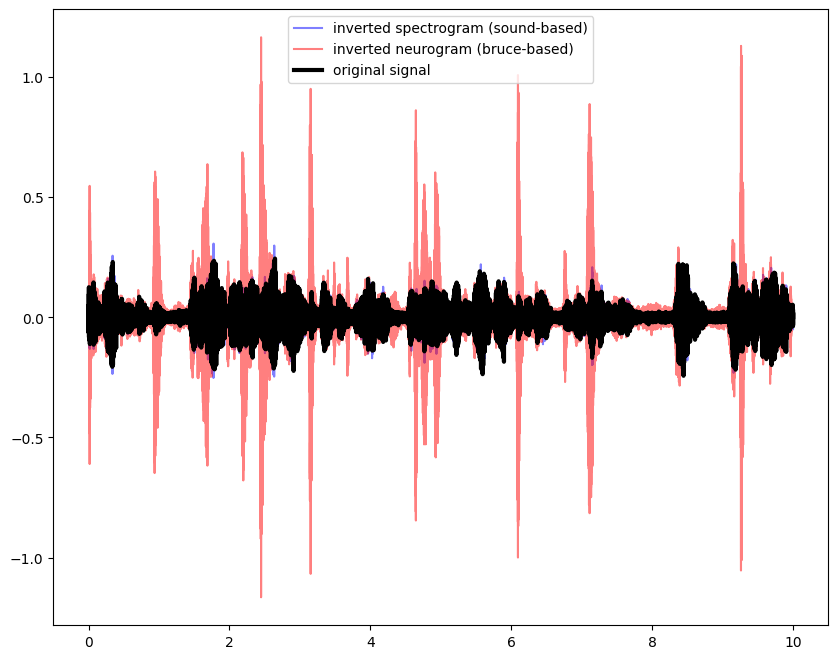

In [14]:
wlen = 512
order = 2

t_mel = np.linspace(0, ng.stim.stimulus_duration, len(mel_inversed))
t_ng = np.linspace(0, ng.stim.stimulus_duration, len(ng_inversed))
t_or = np.linspace(0, ng.stim.stimulus_duration, len(y))
ng_filt = scipy.signal.savgol_filter(ng_inversed, wlen, order)
mel_filt = scipy.signal.savgol_filter(mel_inversed, wlen, order)
plt.figure(figsize=(10, 8))

plt.plot(t_mel, mel_inversed, label="inverted spectrogram (sound-based)", color="blue", alpha=.5)
plt.plot(t_ng, ng_inversed, label="inverted neurogram (bruce-based)", color= "red", alpha=.5)

plt.plot(t_or, y, label="original signal", color="black", linewidth=3)

# plt.plot(
#     t_mel, mel_filt,
#     label="inverted spectrogram (sound-based) (filtered)", color ="blue", linestyle="dashed", alpha=.5
# )

# plt.plot(t_ng, ng_filt, label="inverted neurogram (bruce-based) (filtered)", color="red", linestyle="dashed", alpha=.5)

# plt.grid()
plt.legend()


sf.write(
     f"{REC}/mel_reconstructed_{ng.name}", mel_inversed, sr, subtype='PCM_24'
)
sf.write(
     f"{REC}/ng_reconstructed_{ng.name}", ng_inversed, sr, subtype='PCM_24'
)

# sf.write(
#      f"{REC}/mel_reconstructed_filtered_{ng.name}", mel_filt, sr, subtype='PCM_24'
# )
# sf.write(
#      f"{REC}/ng_reconstructed_filtered_{ng.name}", ng_filt, sr, subtype='PCM_24'
# )
